# Introduction to PyTorch 2.0 and `torch.compile`

PyTorch 2.0 features some things to speed up your model training.

In [1]:
import torch
print(torch.__version__)

2.2.1+cu121


In [2]:
import torch
import torchvision

# example model
model = torchvision.models.resnet50()

# this is the new line in PyTorch 2.0:
compiled_model = torch.compile(model)

In [3]:
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_")
  print(f'GPU name: {GPU_NAME}')

  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: Tesla_T4
GPU capability score: (7, 5)
GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).
GPU information:
Fri Apr  5 19:42:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              12W /  70W |      3MiB / 153

Another new feature is that we can set the device with a context manager (`with`) instead of using `.to(device)`.

In [4]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
  # All tensors or PyTorch objects created in the context manager will be on the target device without using .to()
  layer = torch.nn.Linear(20, 30)
  print(f"Layer weights are on device: {layer.weight.device}")
  print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_default_device(device)

layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


Can set device globally, and then all objects created from then on will be on target advice without using `.to()`.

In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_default_device("cpu")

layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cpu
Layer creating data on device: cpu


Let's run a few experiments to test the speed.

In [7]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.2.1+cu121
TorchVision version: 0.17.1+cu121
Using device: cuda


In [8]:
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
transforms = model_weights.transforms()

transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
model = torchvision.models.resnet50(weights=model_weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
def create_model(num_classes=10):
  """
  Creates a resnet50 model with transforms and returns them both.
  """
  model_weights = torchvision.models.ResNet50_Weights.DEFAULT
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)

  return model, transforms

model, transforms = create_model()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Speedups are most noticeable when a large portion of the GPU is used (e.g. large batch size).

In [11]:
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 15.692 GB
Total GPU memory: 15.836 GB


In [12]:
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 15.692 GB, using batch size of 32 and image size 128


In [13]:
transforms.crop_size = 224
transforms.resize_size = 224
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=224
    resize_size=224
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Possible to get speedups using TensorFloat32 datatype, which is a cross between float32 and float16.

In [14]:
if GPU_SCORE >= (8, 0):
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 not available")
  torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (7, 5), TensorFloat32 not available


In [15]:
import torchvision
train_dataset = torchvision.datasets.CIFAR10(root=".",
                                             train=True,
                                             download=True,
                                             transform=transforms
                                             )

test_dataset = torchvision.datasets.CIFAR10(root=".",
                                            train=False,
                                            download=True,
                                            transform=transforms)

train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

Files already downloaded and verified
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


In [16]:
from torch.utils.data import DataLoader

import os
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# Print details:
print(f"Train dataloader num batches: {len(train_dataloader)} of batch size: {BATCH_SIZE}")
print(f"Test dataloader num batches: {len(test_dataloader)} of batch size: {BATCH_SIZE}")
print(f"Using num workers to load data (more is generally better): {NUM_WORKERS}")

Train dataloader num batches: 1563 of batch size: 32
Test dataloader num batches: 313 of batch size: 32
Using num workers to load data (more is generally better): 2


Just bringing over Daniel's train/test functions.

In [17]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch,
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time

      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

Time to run a few experiments.

Experiment 1: single run, no compile

In [18]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.003
device = "cuda"

In [19]:
model, _ = create_model()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2357 | train_acc: 0.5555 | test_loss: 0.9796 | test_acc: 0.6558 | train_epoch_time: 527.4060 | test_epoch_time: 41.8023


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7734 | train_acc: 0.7297 | test_loss: 0.6388 | test_acc: 0.7769 | train_epoch_time: 534.9741 | test_epoch_time: 38.6321


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5706 | train_acc: 0.8020 | test_loss: 0.5671 | test_acc: 0.8095 | train_epoch_time: 533.7920 | test_epoch_time: 38.6633


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4462 | train_acc: 0.8459 | test_loss: 0.5309 | test_acc: 0.8176 | train_epoch_time: 530.6906 | test_epoch_time: 38.6656


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3473 | train_acc: 0.8784 | test_loss: 0.4463 | test_acc: 0.8477 | train_epoch_time: 530.2480 | test_epoch_time: 38.6689


Experiment 2: single run, using `torch.compile`

In [20]:
model, transforms = create_model()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

compile_start_time = time.time()
compiled_model = torch.compile(model)

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time

print(f"Time to compile: {compile_time}")

single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.005660057067871094


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2448 | train_acc: 0.5504 | test_loss: 0.9642 | test_acc: 0.6547 | train_epoch_time: 666.2487 | test_epoch_time: 66.0658


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.8005 | train_acc: 0.7191 | test_loss: 0.7332 | test_acc: 0.7508 | train_epoch_time: 503.2094 | test_epoch_time: 38.0452


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5970 | train_acc: 0.7923 | test_loss: 0.6273 | test_acc: 0.7755 | train_epoch_time: 511.4061 | test_epoch_time: 38.1750


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4625 | train_acc: 0.8378 | test_loss: 0.5686 | test_acc: 0.8070 | train_epoch_time: 512.7203 | test_epoch_time: 38.4181


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3595 | train_acc: 0.8745 | test_loss: 0.4666 | test_acc: 0.8406 | train_epoch_time: 509.2939 | test_epoch_time: 38.3975


In [21]:
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

Compare Experiments 1 and 2

In [22]:
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool=False,
                          num_runs: int=0,
                          save: bool=False,
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:

    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}%")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}%")

    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds)")

    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: 1.722%
Mean test epoch time difference: 11.541%
[INFO] Plot saved to pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


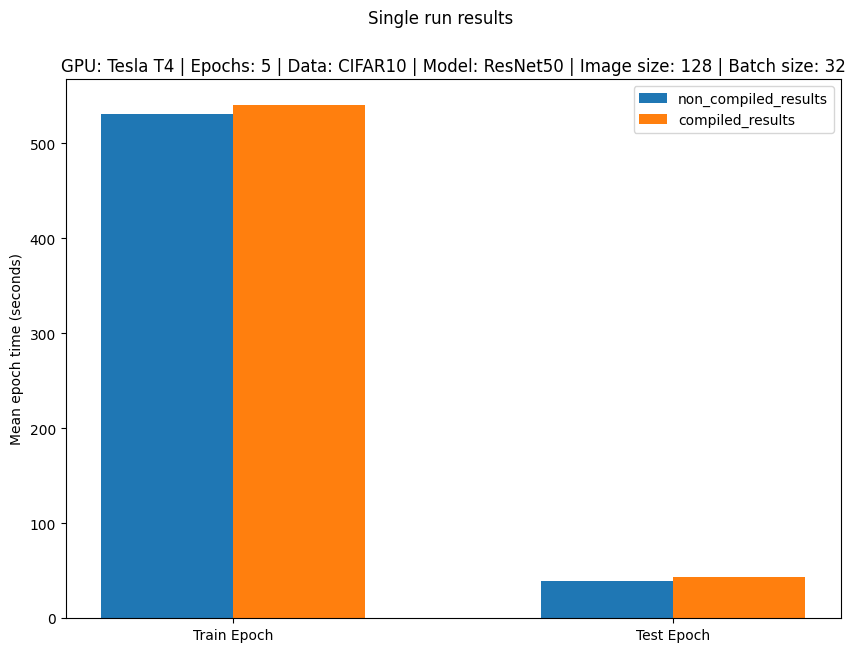

In [24]:
import os
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

save_path_single_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_single_run}")

plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_single_run,
                      save=True)

In [25]:
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv


Compiled version takes longer here because first epoch takes a while due to various optimization processes.  If we did more epochs we would see the speedup.

Experiment 3: multiple runs, no compile.

In [26]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        disable_progress_bar=False):

    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)

    return results

def create_compiled_model():
  """
  Create a compiled PyTorch model and return it.
  """
  model, _ = create_model()
  model.to(device)

  compile_start_time = time.time()

  ### New in PyTorch 2.0!!! ###
  compiled_model = torch.compile(model)

  compile_end_time = time.time()

  compile_time = compile_end_time - compile_start_time

  print(f"[INFO] Model compile time: {compile_time}")

  return compiled_model

def train_compiled_model(model=compiled_model,
                         epochs=NUM_EPOCHS,
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
  """
  Train a compiled model and return the results.
  """
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(compiled_model.parameters(),
                               lr=learning_rate)

  compile_results = train(model=model,
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          epochs=epochs,
                          device=device,
                          disable_progress_bar=disable_progress_bar)

  return compile_results

In [ ]:
NUM_RUNS = 3
NUM_EPOCHS = 5

non_compile_results_multiple_runs = []

for i in tqdm(range(NUM_RUNS)):
  print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
  results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
  non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.2586 | train_acc: 0.5428 | test_loss: 0.9854 | test_acc: 0.6520 | train_epoch_time: 513.9681 | test_epoch_time: 35.7731
Epoch: 2 | train_loss: 0.7986 | train_acc: 0.7201 | test_loss: 0.7397 | test_acc: 0.7469 | train_epoch_time: 521.8467 | test_epoch_time: 36.0725
Epoch: 3 | train_loss: 0.5854 | train_acc: 0.7986 | test_loss: 0.5833 | test_acc: 0.8021 | train_epoch_time: 522.9216 | test_epoch_time: 35.7300
Epoch: 4 | train_loss: 0.4496 | train_acc: 0.8455 | test_loss: 0.5010 | test_acc: 0.8269 | train_epoch_time: 523.4822 | test_epoch_time: 35.9192
Epoch: 5 | train_loss: 0.3562 | train_acc: 0.8756 | test_loss: 0.4924 | test_acc: 0.8389 | train_epoch_time: 524.8604 | test_epoch_time: 35.6268
[INFO] Run 2 of 3 for non-compiled model


In [ ]:
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
  result_df = pd.DataFrame(result)
  non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

Experiment 4: multiple runs, using `torch.compile`

In [ ]:
compiled_model = create_compiled_model()

compiled_results_multiple_runs = []

for i in tqdm(range(NUM_RUNS)):
  print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
  results = train_compiled_model(model=compiled_model,
                                 epochs=NUM_EPOCHS,
                                 disable_progress_bar=False)
  compiled_results_multiple_runs.append(results)

In [ ]:
compile_results_df = []
for result in compiled_results_multiple_runs:
  results_df = pd.DataFrame(result)
  compile_results_df.append(results_df)
compile_results_multiple_runs_df = pd.concat(compile_results_df)

compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean()
compile_results_multiple_runs_df

Compare Experiments 3 and 4

In [ ]:
os.makedirs("pytorch_2_results/figures", exist_ok=True)

save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df,
                      compiled_results=compile_results_multiple_runs_df,
                      multi_runs=True,
                      num_runs=NUM_RUNS,
                      save_path=save_path_multi_run,
                      save=True)

In [ ]:
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)